In [1]:
import os
import sys

import math
from datetime import timezone, datetime
import collections

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import mplfinance as mpf
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import confusion_matrix

In [2]:
sys.path.append("..")
from utils.timescaledbutil import *

from mlfinlab.filters.filters import *
from mlfinlab.labeling.labeling import *

# PostgreSQL(TimeScaleDB)設定
pg_config = {
    'user': os.environ['POSTGRES_USER'],
    'password': os.environ['POSTGRES_PASSWORD'],
    'host': os.environ['POSTGRES_HOST'],
    'port': os.environ['POSTGRES_PORT'],
    'database': os.environ['POSTGRES_DATABASE']
}

# PostgreSQL(TimeScaleDB)に接続する
#dbutil = TimeScaleDBUtil(user = pg_config['user'], password = pg_config['password'], host = pg_config['host'], port = pg_config['port'], database = pg_config['database'])

In [3]:
# 1Mドルバーをデータベースから読み込み、pickleに保存
# 読み出されたバーのインデックスはFTXが運用開始した時点からのドルに換算した売買ボリュームの積算
#df_dollar = dbutil.read_sql_query(sql = "SELECT * FROM btc_perp_dollar_1m WHERE time_from > NOW() - INTERVAL '6 month'", index = 'time_bucket', debug = False)
#df_dollar = df_dollar.drop(['time_to', 'id_from', 'id_to'], axis = 1)
#df_dollar['time_bucket'] = df_dollar.index
#df_dollar.to_pickle('df_dollar_1m_ohlcvl.pkl')

In [4]:
from datetime import timedelta

# ある時点と、その時点からXドル分の売買をさかのぼった時点との間のボラティリティを計算する関数
def calc_volatility(close, delta = 1_000_000 * 16, ewmspan = 96):
    # Find the indices into a sorted Index self such that, if the corresponding elements in value were inserted before the indices, the order of self would be preserved
    array_index = close.index.searchsorted(close.index - delta)
    
    # Extract index larger than 0 (Which means, the row has another row which is x timedelta before)
    array_index = array_index[array_index > 0]
    
    # Prepare a series which index points the origin row and the value points the row x timedelta before from the origin row
    ser = pd.Series(array_index - 1, index = range(close.shape[0] - array_index.shape[0], len(close)))
    
    # Xドル分さかのぼった地点との対数リターンの指数移動平均の標準偏差を取り、ボラティリティのデータフレームとして返す
    df = pd.DataFrame(data = {'volatility': np.log(close.iloc[ser.index]['close']) - np.log(close.iloc[ser]['close'].values)}, index = close.iloc[ser.index].index)
    df['volatility'] = df['volatility'].ewm(span = ewmspan).std()
    return df

In [5]:
# 直前の加工済みデータフレームを読み込む
df_dollar = pd.read_pickle('df_dollar_1m_ohlcvl.pkl')

# 対数リターンをデータフレームに追加し、NaNを含む行を削除
df_dollar['close_log_return'] = df_dollar['close'].apply(np.log).diff()
df_dollar = df_dollar.dropna()

# 400万ドルの売買ボリュームをさかのぼった時点からのボラティリティを計算し、データフレームに追加する
df_volatility = calc_volatility(df_dollar[['close']], 4 * 1_000_000, ewmspan = 64)
df_dollar.loc[:,'volatility']  = df_volatility['volatility']
df_dollar.dropna(inplace = True)

# 加工済みデータフレームを保存する
df_dollar.to_pickle('df_dollar_1m_ohlcvl_volatility.pkl')

In [6]:
# 直前の加工済みデータフレームを読み込む
df_dollar = pd.read_pickle('df_dollar_1m_ohlcvl_volatility.pkl')

# ボラティリティの標準偏差の二倍としたCUSUMフィルタを実行し、発生したイベントを記録する
cusum_events = cusum_filter(df_dollar['close'], df_dollar['volatility'] * 2, time_stamps = False)
ser_cusum_events = pd.Series(cusum_events)

# トリプルバリア法の垂直バリア時間を記録する
vertical_barrier_times = add_vertical_barrier_dollar(t_events=ser_cusum_events, close=df_dollar['close'], dollardelta = 4 * 1_000_000)

# トリプルバリア法を適応し、発生したイベントを記録する
triple_barrier_events = get_events(df_dollar['close'],
           ser_cusum_events,
           [1, 1],
           df_dollar['volatility'],
           0,
           4,
           vertical_barrier_times = vertical_barrier_times,
           side_prediction = None)

# トリプルバリア法に基づいて発生したイベントに、丈夫バリアと接触(1), 下部バリアと接触(-1), 垂直バリアと接触(0)のラベルをつける
# binary=Trueの場合は、上昇(1), 下降(-1)の二値のラベルを付ける
meta_labels = get_bins(triple_barrier_events, df_dollar['close'], binary=True)
bin_index = meta_labels.index
df_dollar.loc[:,'bin'] = np.nan
df_dollar.loc[bin_index, 'bin'] = meta_labels.loc[bin_index, 'bin']
df_dollar.loc[bin_index, 'ret'] = meta_labels.loc[bin_index, 'ret']

# 加工済みデータフレームを保存する
df_dollar.to_pickle('df_dollar_1m_ohlcvl_volatility_bin.pkl')

In [8]:
# CUSUMイベントをチャートとともに表示する関数
def plot_chart():
    df_dollar_plt = pd.read_pickle('df_dollar_1m_ohlcvl_volatility_cusummarker_bin.pkl')

    bin_0_index = meta_labels[meta_labels['bin'] == 0].index
    df_dollar_plt.loc[:,'bin_0_marker'] = np.nan
    df_dollar_plt.loc[bin_0_index, 'bin_0_marker'] = df_dollar.loc[bin_0_index, 'close']

    bin_1_index = meta_labels[meta_labels['bin'] == 1].index
    df_dollar_plt.loc[:,'bin_1_marker'] = np.nan
    df_dollar_plt.loc[bin_1_index, 'bin_1_marker'] = df_dollar.loc[bin_1_index, 'close']

    bin_m1_index = meta_labels[meta_labels['bin'] == -1].index
    df_dollar_plt.loc[:,'bin_m1_marker'] = np.nan
    df_dollar_plt.loc[bin_m1_index, 'bin_m1_marker'] = df_dollar.loc[bin_m1_index, 'close']

    df_dollar_plt = df_dollar_plt.set_index('time_from', drop = False)
    apd = [mpf.make_addplot(df_dollar_plt['liquidation_sell_volume'], panel = 1),
           mpf.make_addplot(df_dollar_plt['liquidation_buy_volume'], panel = 2),
           mpf.make_addplot(df_dollar_plt['bin_0_marker'], type='scatter', marker='^', color='green', markersize = 10, panel = 0),
           mpf.make_addplot(df_dollar_plt['bin_1_marker'], type='scatter', marker='.', color='black', markersize = 10, panel = 0),
           mpf.make_addplot(df_dollar_plt['bin_m1_marker'], type='scatter', marker='v', color='red', markersize = 10, panel = 0)]
    mpf.plot(df_dollar_plt, type='line', volume=False, addplot=apd, figratio=(24,6))

# チャートを表示して動作を確認する
#plot_chart()

In [9]:
import talib
import copy

# richmanbtcさんのサンプルから取った、特徴量計算用関数、売買ボリュームや清算ボリュームなどを追加した
def calc_features(df):
    open = df['open']
    high = df['high']
    low = df['low']
    close = df['close']
    volume = df['volume']
    
    orig_columns = df.columns
    
    hilo = (df['high'] + df['low']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    return df

# 機械学習に利用する特徴量の一覧
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
    'MINUS_DI',
    'MINUS_DM',
    'MOM',
    'PLUS_DI',
    'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
    'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
    'ADOSC',
    'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
    'liquidation_buy_volume',
    'liquidation_sell_volume',
    'close',
    'close_log_return',
    'volatility',
    'buy_volume',
    'sell_volume'
])

In [10]:
# 直前の加工済みデータフレームを読み込む
df_dollar = pd.read_pickle('df_dollar_1m_ohlcvl_volatility_bin.pkl')

# 特徴量を計算する
df_dollar = calc_features(df_dollar)

# 加工済みデータフレームを保存する
df_dollar.to_pickle('df_dollar_1m_ohlcvl_volatility_bin_features.pkl')

In [11]:
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

def fit_and_predict(df, features = []):
    # モデル (コメントアウトで他モデルも試してみてください)
    # model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
    #model = lgb.LGBMClassifier(objective='multiclass', class_weight='balanced')
    model = lgb.LGBMClassifier(objective='binary', max_depth=8, num_leaves=192)
    
    # アンサンブル (コメントアウトを外して性能を比較してみてください)
    # model = BaggingRegressor(model, random_state=1, n_jobs=1)

    # 本番用モデルの学習 (このチュートリアルでは使わない)
    # 実稼働する用のモデルはデータ全体で学習させると良い
    features_fit_target = copy.deepcopy(features)
    features_fit_target.append('bin')
    
    df_fit_target = df[features_fit_target]
    df_fit_target.where(df_fit_target < sys.float_info.max, np.inf, inplace = True)
    df_fit_target.where(df_fit_target > -sys.float_info.max, -np.inf, inplace = True)
    df_fit_target.replace([np.inf, -np.inf], np.nan, inplace =  True)
    df_fit_target.dropna(inplace = True)
    #df_fit_target.reset_index(drop = True, inplace = True)
    
    model.fit(df_fit_target[features], df_fit_target['bin'])
    #joblib.dump(model, 'model_y_buy.xz', compress=True) 

    # 通常のCV
    cv_indicies = list(KFold().split(df_fit_target))
    # ウォークフォワード法
    # cv_indicies = list(TimeSeriesSplit().split(df))
    
    df_fit_target['bin_pred'] = my_cross_val_predict(model, df_fit_target[features].values, df_fit_target['bin'].values, cv=cv_indicies)
    
    fit_target_index = df_fit_target.index
    df.loc[fit_target_index, 'bin_pred'] = df_fit_target.loc[fit_target_index, 'bin_pred']

    return (df, model)

In [12]:
# 直前の加工済みデータフレームを読み込む
df_dollar = pd.read_pickle('df_dollar_1m_ohlcvl_volatility_bin_features.pkl')

# データフレームからトリプルバリア法によるラベル付けがされている行だけを抽出する
df_dollar = df_dollar[pd.isnull(df_dollar['bin']) == False]

shift_features = [] # 過去の特徴量を列として追加する際に利用するラベル名一覧

# それぞれの行から8行前までの過去の特徴量を、列としてデータフレームに追加していく
# 過去の特徴量はそれぞれ異なる列名を持ち、全ての列名の一覧はshift_featuresに追加される
for i in range(1, 9):
    df_dollar_shift = df_dollar.shift(i)
    df_dollar_shift = df_dollar_shift[features]
    df_dollar_shift = df_dollar_shift.add_suffix(f"_{i}")
    df_dollar = pd.concat([df_dollar, df_dollar_shift], axis=1)
    shift_features = shift_features + df_dollar_shift.columns.values.tolist()

# 特徴量featuresと過去分の特徴量shift_featuresを利用して、binの値を推測するモデルを作成し、そのモデルを利用してdataフレームのbin_pred列に予測値を書き込む
(df_dollar, model) = fit_and_predict(df_dollar, features + shift_features)

# モデルを保存しておく
joblib.dump(model, 'model.xz', compress=True) 

# 予測値がある行のみを抜き出す
df_dollar = df_dollar[pd.isna(df_dollar['bin_pred']) == False]

# 加工済みデータフレームを保存する
df_dollar.to_pickle('df_dollar_1m_ohlcvl_volatility_bin_features_predict.pkl')

/opt/conda/lib/python3.9/site-packages/pandas/core/generic.py:9032: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(cond, other, inplace, axis, level, errors=errors)
/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
/opt/conda/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret

<AxesSubplot:>

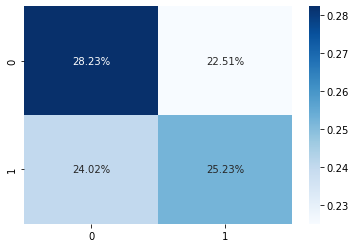

In [13]:
# 直前の加工済みデータフレームを読み込む
df_dollar = pd.read_pickle('df_dollar_1m_ohlcvl_volatility_bin_features_predict.pkl')

# Confusion matrixを計算して表示する
df_dollar_confusion = df_dollar[['bin', 'bin_pred']]
cf_matrix = confusion_matrix(df_dollar_confusion['bin'], df_dollar_confusion['bin_pred'])
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
#sns.heatmap(cf_matrix, annot=True, cmap='Blues')

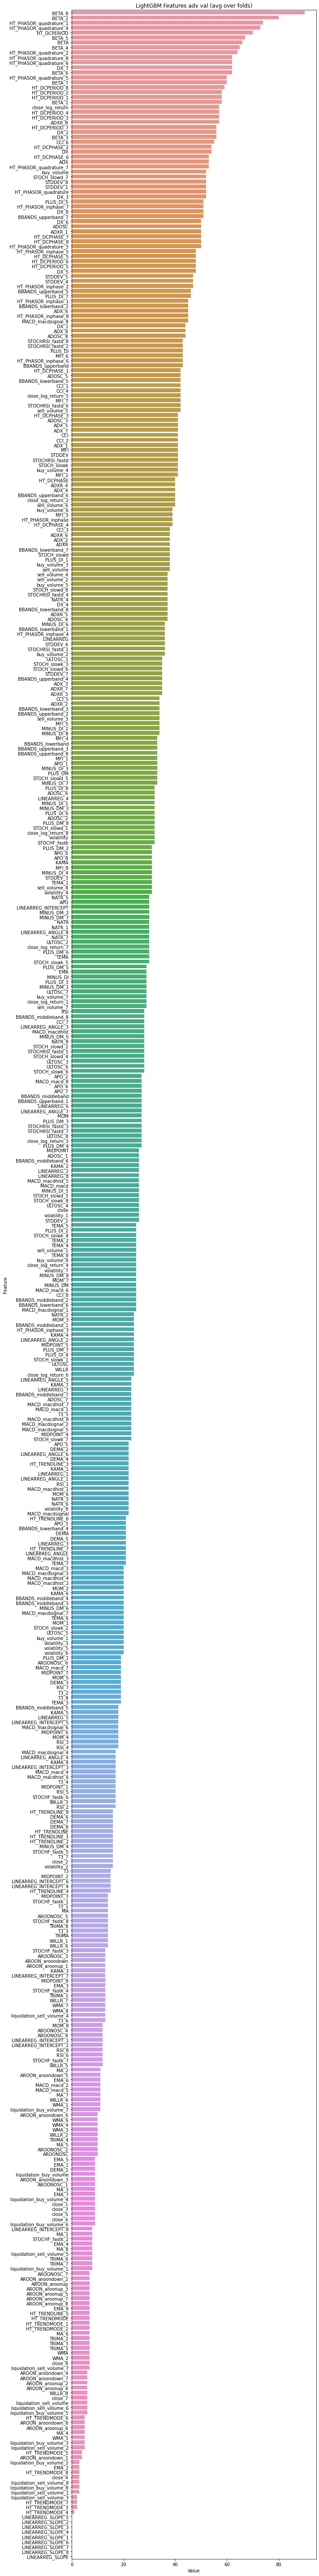

In [14]:
# 特徴量の重要度を表示する
lgbm_adv_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, features + shift_features)), columns=['Value','Feature'])
plt.figure(figsize=(10, 80))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features adv val (avg over folds)')
plt.tight_layout()
plt.show()